In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import moca, fit_psi_params, psi_params, ellipse_aspect_ratio

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None


In [2]:
def find_root(x, y):
    coeffs = np.polyfit(x, y, 3)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid = x[len(x)//2]
    return real_roots[np.argmin(np.abs(mid - real_roots))]

def tang_at_root(x, y, rx):
    coeffs = np.polyfit(x, y, 3)
    deriv = np.polyder(coeffs)
    slope = np.polyval(deriv, rx)
    intercept = np.polyval(coeffs, rx) - slope * rx
    return slope, intercept

def cubic_interpolate(x, y, root):
    coeffs = np.polyfit(x, y, 3)
    return np.polyval(coeffs, root)

def unit_det(Q, symmetrize=True):
    Q = np.asarray(Q, dtype=float)
    d = np.linalg.det(Q)
    if not np.isfinite(d) or d <= 0: raise ValueError("det(Q) must be positive and finite")
    s = 1/np.sqrt(d)
    return s*Q, s

def circle(xc, yc, r, n=200):
    theta = np.linspace(0, 2*np.pi, n)
    x = xc + r * np.cos(theta)
    y = yc + r * np.sin(theta)
    return x, y
    

In [3]:
width=500
x = np.linspace(-width // 2, width // 2, 501)
y = np.linspace(-width // 2, width // 2, 501)
X, Y = np.meshgrid(x, y, indexing='ij')

xc, yc = 0.0, 0.0
Q11, Q12, Q22 = 1, 0, 1
psi0 = 250
Rc = 85.0
A = - psi0 / Rc**2 

# rescale Q to have unit determinant
Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

dx, dy = X - xc, Y - yc
rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
Qr2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2 # ||Qr||
psi = psi0 * np.exp( - rho2 / Rc**2 )
u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2


,xc,yc,w,q11,q12,q22,Rc,psi0,A
Control,0.000000e+00,0.000000,-0.000138,1.0,0.0,1.0,85.000000,250.000000,-0.034602
P1,0.000000e+00,-0.643841,-0.000124,1.0,-0.0,1.0,86.113585,252.937780,-0.034109
P2,-7.105427e-14,-1.609602,-0.000093,1.0,-0.0,1.0,86.324602,253.408999,-0.034006
P3,0.000000e+00,-2.575363,-0.000054,1.0,-0.0,1.0,85.883518,257.198220,-0.034870
L1,2.131628e-14,-0.084143,-0.000130,1.0,-0.0,1.0,85.486119,252.036601,-0.034488
L2,0.000000e+00,-0.643841,-0.000124,1.0,-0.0,1.0,86.113585,252.937780,-0.034109
L3,-5.684342e-14,-2.113639,-0.000112,1.0,-0.0,1.0,86.755294,251.962366,-0.033477


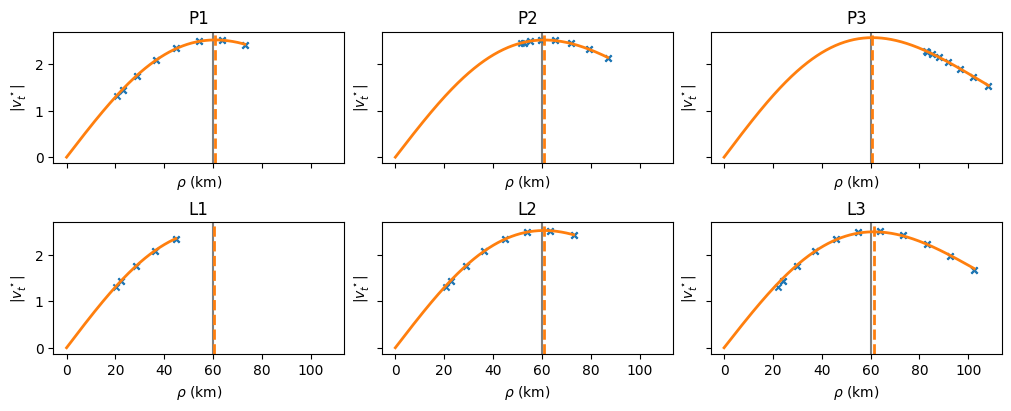

In [4]:
df_res = pd.DataFrame({'xc': [xc], 'yc': [yc], 'w': [2*A*(q11+q22)*1e-3], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                        'Rc': [Rc], 'psi0': [psi0], 'A': [A]})

nic, njc = 50, 60
r = 14

df_tests = pd.DataFrame({
    'nic': [nic, nic, nic, nic, nic, nic],
    'njc': [54, njc, 66, 54, 54, 54],
    'r': [r, r, r, 8, r, 20]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

df_tests = df_tests*5

dic_tests = {}

fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(10, 4), sharey=True, sharex=True)
axs = axs.flatten()

skip = 10
for t, test in enumerate(df_tests.index):
    data = df_tests.loc[test]

    x1 = x[data.nic-data.r:data.nic+data.r+1:skip]
    y1 = np.array([y[data.njc]] * len(x1))
    l = x1 - x1[0]
    
    u1 = u[data.nic-data.r:data.nic+data.r+1:skip, data.njc]
    v1 = v[data.nic-data.r:data.nic+data.r+1:skip, data.njc]

    l0, r0, w_moc, Q_moc, Rc_moc, psi0_moc, A_moc = moca(l, u1, v1, plot_flag=False)
    xc_moc, yc_moc = l0 + x1[0], r0 + y1[0]
    w_moc *= 1e-3

    df = psi_params(xc_moc, yc_moc, Q_moc, x1, y1, u1, v1)
    fit_psi_params(df.rho2, df.Qr, df.vt, r2_flag=True, 
                                     plot=True, Rc_max=1e6, ax=axs[t]) 
                      
    dic_tests[test] = {'x1': x1, 'y1': y1, 'l': l, 'u1': u1, 'v1': v1, 'name': test}
    df_res.loc[len(df_res)] = {'xc': xc_moc, 'yc': yc_moc, 'w': w_moc,
                               'q11': Q_moc[0,0], 'q12': Q_moc[0,1], 'q22': Q[1,1],
                               'Rc': Rc_moc, 'psi0': psi0_moc, 'A': A_moc}

for a, ax in enumerate(axs):
    # if a%2==0:
    ax.set_title(df_tests.index[a])
    ax.set_xlabel(r'$\rho$ (km)')
    ax.axvline(Rc/np.sqrt(2), color='k', zorder=-1, alpha=.5)
    
df_res.index = ['Control'] +  list(df_tests.index)
df_res


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


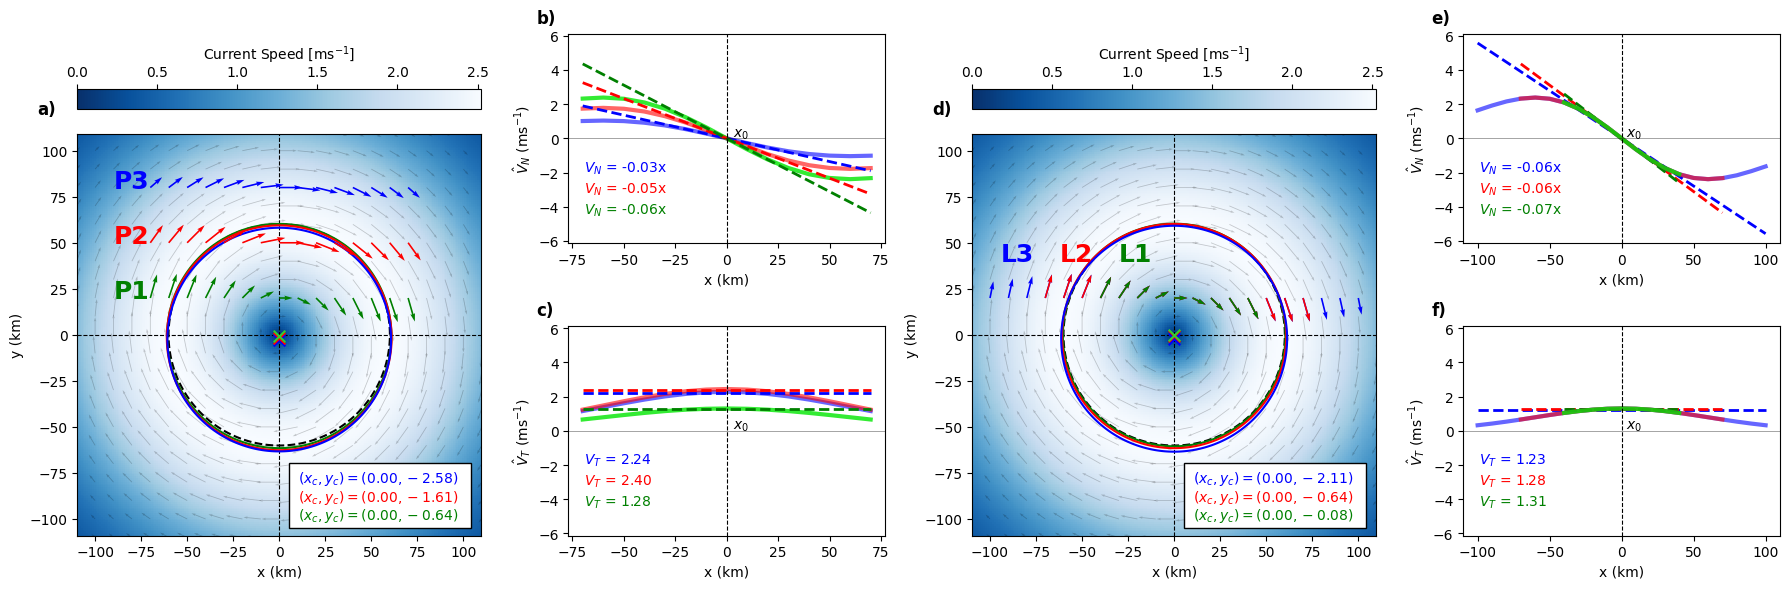

In [5]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 6, figure=fig, width_ratios=[1, 1, 2, 1, 1, 2])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pc = ax_main_left.pcolor(x, y, np.hypot(u, v), cmap='Blues_r', zorder=0)
plt.colorbar(pc, ax=ax_main_left, orientation='horizontal', location='top', label=r'Current Speed [ms$^{-1}$]')
ax_main_left.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=0)
ax_main_left.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=0)

spacing = 2*5
scale = 40
width = 0.002
alpha = 1
quiv = ax_main_left.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
                           alpha=.2, scale=scale, width=width, zorder=1)

ax_main_left.contour(X, Y, rho2, levels=[Rc**2/2],
                     colors='k', linestyles='--')

colors = ['limegreen', 'r', 'b']
color = ['g', 'r', 'b']
color_fits = [(0, .9, 0, 0.8), (1, 0, 0, 0.6), (0, 0, 1, 0.6)]
i = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:
        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']
        data = df_res.loc[dic['name']]
        
        ax_main_left.text(x1[0]-20, y1[0], dic['name'], color=color[i],
                          zorder=3, fontsize=18, fontweight='bold')
        ax_main_left.quiver(x1, y1, u1, v1,
                            scale=scale, width=width*2, color=color[i], zorder=3)
        ax_main_left.scatter(data.xc, data.yc, color=colors[i], marker='x', s=70, zorder=10-extract_number(dic['name']))

        dx_ell, dy_ell = X - data.xc, Y - data.yc
        rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
        ax_main_left.contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors=color[i])
        
        ax_main_left.text(10, (-100 + 10*i), fr'$(x_c,y_c)=({np.abs(data.xc):.2f},{data.yc:.2f})$',
                          color=color[i], zorder=10)

        i += 1
        
x_pos, y_pos = 0.75, 0.1
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_left.transAxes,
                       facecolor='white', edgecolor='black', zorder=9)
ax_main_left.add_patch(rect)
ax_main_left.axis('equal')
ax_main_left.set_xlim(-100, 100)
ax_main_left.set_ylim(-100, 100)
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.text(-0.1, 1.05, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

j = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']
        data = df_res.loc[dic['name']]
        
        root = find_root(x1, v1)
        c, b = tang_at_root(x1, v1, root)
        a = cubic_interpolate(x1, u1, root)

        # ax2_left.text(0.05, 0.2 + 0.1 * j, fr"$V_N$ = {c:.2f}x {'+' if b > 0 else '-'} {abs(b):.2f}", transform=ax2_left.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax2_left.text(0.05, 0.2 + 0.1 * j, fr"$V_N$ = {c:.2f}x", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])
        ax3_left.text(0.05, 0.2 + 0.1 * j, fr"$V_T$ = {a:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        root = find_root(x1, v1)
        c, b = tang_at_root(x1, v1, root)
        a = cubic_interpolate(x1, u1, root)

        p_v1 = c*x1 + b
        p_u1 = [a]*len(x1)

        ax2_left.plot(x1, v1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name'])-3)
        ax2_left.plot(x1, p_v1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))

        ax3_left.plot(x1, u1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name'])-3)
        ax3_left.plot(x1, p_u1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))
        j += 1

ax2_left.text(3, .13, r'$x_0$')
ax3_left.text(3, .13, r'$x_0$')
        
ax2_left.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.set_ylabel(r'$\hat{V}_N$ (ms$^{-1}$)')
ax2_left.set_xlabel('x (km)')
ax2_left.text(-0.1, 1.05, 'b)', transform=ax2_left.transAxes, fontsize=12, fontweight='bold')
ax3_left.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.set_ylabel(r'$\hat{V}_T$ (ms$^{-1}$)')
ax3_left.set_xlabel('x (km)')
ax3_left.text(-0.1, 1.05, 'c)', transform=ax3_left.transAxes, fontsize=12, fontweight='bold')

# Right PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 3:5])
pc = ax_main_right.pcolor(x, y, np.hypot(u, v), cmap='Blues_r')
plt.colorbar(pc, ax=ax_main_right, orientation='horizontal', location='top', label=r'Current Speed [ms$^{-1}$]')
ax_main_right.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_right.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
quiv = ax_main_right.quiver(x[::spacing], y[::spacing],
                            u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
                            alpha=.2, scale=scale, width=width)

ax_main_right.contour(X, Y, rho2, levels=[Rc**2/2],
                     colors='k', linestyles='--')

i = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:
        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']
        data = df_res.loc[dic['name']]
        
        ax_main_right.quiver(x1, y1, u1, v1,
                             scale=scale, width=width*2, color=color[i], zorder=5-i)
        ax_main_right.scatter(data.xc, data.yc, color=colors[i], marker='x', s=70, zorder=10-extract_number(dic['name']))
        ax_main_right.text(10, (-100 + 10*i), fr'$(x_c,y_c)=({np.abs(data.xc):.2f},{data.yc:.2f})$',
                           color=color[i], zorder=10)

        dx_ell, dy_ell = X - data.xc, Y - data.yc
        rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
        ax_main_right.contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors=color[i])

        ax_main_right.text(x1[0]+(-i*2 +10), y1[0]+20, dic['name'],
                           color=color[i], zorder=3, fontsize=18, fontweight='bold')
 
        i += 1
x_pos, y_pos = 0.75, 0.1
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_right.transAxes,
                       facecolor='white', edgecolor='black', zorder=9)
ax_main_right.add_patch(rect)
ax_main_right.axis('equal')
ax_main_right.set_xlim(-100, 100)
ax_main_right.set_ylim(-100, 100)
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')
ax_main_right.text(-0.1, 1.05, 'd)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 5])
ax3_right = fig.add_subplot(gs[1, 5])

j = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:
        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']
        data = df_res.loc[dic['name']]
        
        root = find_root(x1, v1)
        c, b = tang_at_root(x1, v1, root)
        a = cubic_interpolate(x1, u1, root)

        # ax2_right.text(0.05, 0.2 + 0.1 * j, fr"$V_N$ = {c:.2f}x {'+' if b > 0 else '-'} {abs(b):.2f}", transform=ax2_right.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax2_right.text(0.05, 0.2 + 0.1 * j, fr"$V_N$ = {c:.2f}x", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])
        ax3_right.text(0.05, 0.2 + 0.1 * j, fr"$V_T$ = {a:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        root = find_root(x1, v1)
        c, b = tang_at_root(x1, v1, root)
        a = cubic_interpolate(x1, u1, root)

        p_v1 = c*x1 + b
        p_u1 = [a]*len(x1)

        ax2_right.plot(x1, v1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax2_right.plot(x1, p_v1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name'])-3)

        ax3_right.plot(x1, u1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax3_right.plot(x1, p_u1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name'])-3)

        j += 1

ax2_right.text(3, .13, r'$x_0$')
ax3_right.text(3, .13, r'$x_0$')

ax2_right.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.set_ylabel(r'$\hat{V}_N$ (ms$^{-1}$)')
ax2_right.text(-0.1, 1.05, 'e)', transform=ax2_right.transAxes, fontsize=12, fontweight='bold')
ax2_right.set_xlabel('x (km)')

ax3_right.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.set_ylabel(r'$\hat{V}_T$ (ms$^{-1}$)')
ax3_right.set_xlabel('x (km)')
ax3_right.text(-0.1, 1.05, 'f)', transform=ax3_right.transAxes, fontsize=12, fontweight='bold')
ax3_right.set_xlabel('x (km)')


axs = [ax2_left, ax3_left, ax2_right, ax3_right]
ymin, ymax = np.inf, -np.inf
for ax in axs:
    ymin = min(ymin, ax.get_ylim()[0])
    ymax = max(ymax, ax.get_ylim()[1])

for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


In [6]:
df_res


,xc,yc,w,q11,q12,q22,Rc,psi0,A
Control,0.000000e+00,0.000000,-0.000138,1.0,0.0,1.0,85.000000,250.000000,-0.034602
P1,0.000000e+00,-0.643841,-0.000124,1.0,-0.0,1.0,86.113585,252.937780,-0.034109
P2,-7.105427e-14,-1.609602,-0.000093,1.0,-0.0,1.0,86.324602,253.408999,-0.034006
P3,0.000000e+00,-2.575363,-0.000054,1.0,-0.0,1.0,85.883518,257.198220,-0.034870
L1,2.131628e-14,-0.084143,-0.000130,1.0,-0.0,1.0,85.486119,252.036601,-0.034488
L2,0.000000e+00,-0.643841,-0.000124,1.0,-0.0,1.0,86.113585,252.937780,-0.034109
L3,-5.684342e-14,-2.113639,-0.000112,1.0,-0.0,1.0,86.755294,251.962366,-0.033477


In [7]:
df_err = (df_res - df_res.iloc[0]).abs().iloc[1:]
df_err.index = ['P1 Err', 'P2 Err', 'P3 Err',
                'L1 Err', 'L2 Err', 'L3 Err']
df_err


,xc,yc,w,q11,q12,q22,Rc,psi0,A
P1 Err,0.000000e+00,0.643841,0.000014,1.110223e-16,0.0,0.0,1.113585,2.937780,0.000493
P2 Err,7.105427e-14,1.609602,0.000045,2.220446e-16,0.0,0.0,1.324602,3.408999,0.000596
P3 Err,0.000000e+00,2.575363,0.000084,3.330669e-16,0.0,0.0,0.883518,7.198220,0.000268
L1 Err,2.131628e-14,0.084143,0.000008,2.220446e-16,0.0,0.0,0.486119,2.036601,0.000114
L2 Err,0.000000e+00,0.643841,0.000014,1.110223e-16,0.0,0.0,1.113585,2.937780,0.000493
L3 Err,5.684342e-14,2.113639,0.000027,0.000000e+00,0.0,0.0,1.755294,1.962366,0.001125


#### Simpler display of MOCA improvements

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Actual vorticity -0.0001384083044982699
-0.00013840830449827002
-2.124768947622342e-05


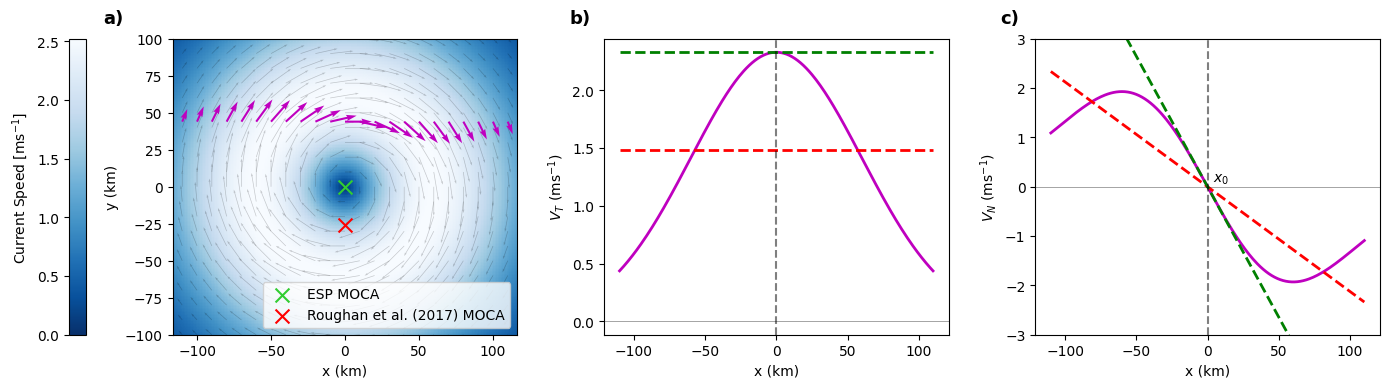

In [8]:
from matplotlib.gridspec import GridSpec

i1, i2 = 140, 360
j = 294

scale = 30
width = 0.002

x1 = x[i1:i2+1]
y1 = [y[j]] * len(x1)

u1 = u[i1:i2+1, j]
v1 = v[i1:i2+1, j]

VT = -2*A*(q22*(y[j]-yc)+q12*(x1-xc))
VN =  2*A*(q11*(x1-xc)+q12*(y[j]-yc))

spac = 2*5

fig = plt.figure(figsize=(14,4))

# 4 columns: [COLORBAR | AX0 | AX1 | AX2]
gs = GridSpec(1, 4, width_ratios=[0.05, 1, 1, 1], figure=fig)

cax = fig.add_subplot(gs[0, 0])
axs = [fig.add_subplot(gs[0, i]) for i in range(1, 4)]  # axs[0], axs[1], axs[2]

im = axs[0].pcolor(X, Y, np.hypot(u, v), cmap='Blues_r')
fig.colorbar(im, cax=cax, location='left', label=r'Current Speed [ms$^{-1}$]')


axs[0].quiver(X[::spac,::spac], Y[::spac,::spac], u[::spac,::spac], v[::spac,::spac],
             scale=scale, width=width, alpha=.2)
axs[0].quiver(x1[::spac], y1[::spac], u1[::spac], v1[::spac],
              color='m', scale=scale, width=width*3)

print(f'Actual vorticity {df_res.iloc[0].w}')

Omega = (v1[(len(v1)//2) + 1] - v1[(len(v1)//2)]) / (x1[1]-x1[0])
# print(Omega*1e-3)
r0 = np.max(u1) / Omega
l0 = -x1[0]
x0, y0 = x1[0] + l0, r0 + y1[0]
axs[0].scatter(x0, y0, marker='x', color='limegreen', s=100, label=fr'ESP MOCA')#, $\omega={Omega}$')
_, _, w_check, _, _, _, _ = moca(x1-x1[0], VT, VN)
print(w_check*1e-3)

pf_u = np.poly1d(np.polyfit(x1, u1, 0))
pf_v = np.poly1d(np.polyfit(x1, v1, 1))
Omega1 = pf_v[1]
print(Omega1*1e-3)
r01 = pf_u[0] / Omega1
l01 = -x1[0]
x01, y01 = x1[0] + l01, r01 + y1[0]
axs[0].scatter(x01, y01, marker='x', color='r', s=100, label=fr'Roughan et al. (2017) MOCA')#,\n $\omega={Omega1}$')

axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
axs[0].axis('equal'); axs[0].legend(loc='lower right')
axs[0].set_xlim(-100, 100)
axs[0].set_ylim(-100, 100)
axs[0].text(-.2, 1.1, 'a)', transform=axs[0].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

axs[1].plot(x1, u1, 'm', lw=2)
axs[1].plot(x1, pf_u(x1), ls='--', color='r', lw=2)
axs[1].plot(x1, [np.max(u1)] * len(x1), ls='--', color='g', lw=2)
axs[1].axvline(x=0, ls='--', color='k', alpha=.5)
axs[1].axhline(y=0, lw=.5, color='k', alpha=.5)
axs[1].set_xlabel('x (km)'); axs[1].set_ylabel(r'$V_T$ (ms$^{-1}$)')
axs[1].text(-.1, 1.1, 'b)', transform=axs[1].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

axs[2].plot(x1, v1, 'm', lw=2)
axs[2].plot(x1, pf_v(x1), ls='--', color='r', lw=2)
axs[2].plot(x1, Omega*x1, ls='--', color='g', lw=2)
axs[2].axvline(x=0, ls='--', color='k', alpha=.5)
axs[2].axhline(y=0, lw=.5, color='k', alpha=.5)
axs[2].text(4,0.1, r'$x_0$')
axs[2].set_ylim(-3, 3)
axs[2].set_xlabel('x (km)'); axs[2].set_ylabel(r'$V_N$ (ms$^{-1}$)') 
axs[2].text(-.1, 1.1, 'c)', transform=axs[2].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

plt.tight_layout()


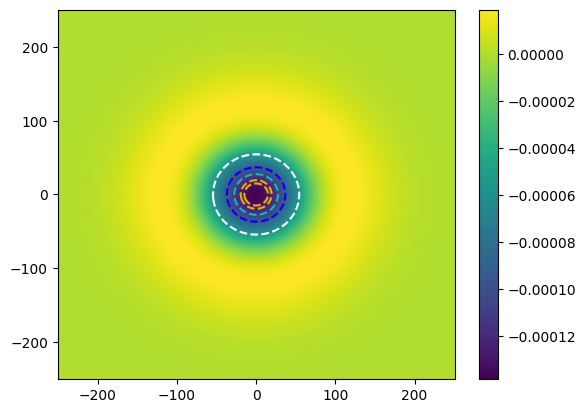

In [9]:
dx = (X[1,0] - X[0,0])*1e3
dy = (Y[0,1] - Y[0,0])*1e3

dv_dx = np.gradient(v, dx, axis=0)
du_dy = np.gradient(u, dy, axis=1)

zeta = dv_dx - du_dy
plt.pcolor(X, Y, zeta)
plt.colorbar()
clrs =['r', 'm', 'b', 'w', 'orange', 'y', 'c']
for i, clr in enumerate(clrs):
    plt.contour(X, Y, zeta, levels=[df_res.iloc[i].w], colors=clr) 
    

In [10]:
def deform_eddy(Q11=1, Q12=0, Q22=1):
    width=500
    x = np.linspace(-width // 2, width // 2, 501)
    y = np.linspace(-width // 2, width // 2, 501)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    xc, yc = 0.0, 0.0

    psi0 = 250
    Rc = 85.0
    A = - psi0 / Rc**2 
    
    # rescale Q to have unit determinant
    Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
    q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]
    
    dx, dy = X - xc, Y - yc
    rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
    Qr2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2 # ||Qr||
    psi = psi0 * np.exp( - rho2 / Rc**2 )
    u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
    v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2

    nic, njc, r = 250, 270, 70
    skip = 10
    x1 = x[nic-r:nic+r+1:skip]
    y1 = np.array([y[njc]] * len(x1))    
    l = x1 - x1[0]
    u1 = u[nic-r:nic+r+1:skip, njc]
    v1 = v[nic-r:nic+r+1:skip, njc]

    l0, r0, w_moc, Q_moc, Rc_moc, psi0_moc, A_moc = moca(l, u1, v1)
    xc_moc, yc_moc = l0 + x1[0], r0 + y1[0]
    
    return xc_moc, yc_moc, w_moc, Q_moc, Rc_moc, psi0_moc, A_moc, q11, q12, q22


df_deform_tests = pd.DataFrame({'xc': [xc], 'yc': [yc], 'w': [2*A*(q11+q22)*1e-3], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                        'Rc': [Rc], 'psi0': [psi0], 'A': [A], 'Q11': np.nan, 'Q12': np.nan, 'Q22': np.nan})

for Q12 in np.arange(0.0, .8 + 0.05, 0.05):
    xc_moc, yc_moc, w_moc, Q_moc, Rc_moc, psi0_moc, A_moc, Q11, Q12, Q22 = deform_eddy(Q12=Q12)
    df_deform_tests.loc[len(df_deform_tests)] = {'xc': xc_moc, 'yc': yc_moc, 'w': w_moc, 'q11': Q_moc[0,0], 'q12': Q_moc[1,0], 'q22': Q_moc[1,1],
                        'Rc': Rc_moc, 'psi0': psi0_moc, 'A': A_moc, 'Q11': Q11, 'Q12': Q12, 'Q22': Q22}
df_deform_tests = df_deform_tests.iloc[1:]
df_deform_tests


,xc,yc,w,q11,q12,q22,Rc,psi0,A,Q11,Q12,Q22
1,0.000000,-0.643841,-0.124462,1.0,-0.0,1.0,86.113585,252.937780,-0.034109,1.000000,0.000000,1.000000
2,-0.962650,-0.597775,-0.124592,1.0,-0.0,1.0,86.138349,253.234148,-0.034129,1.001252,0.050063,1.001252
3,-1.925474,-0.459532,-0.124984,1.0,-0.0,1.0,86.207103,254.106624,-0.034192,1.005038,0.100504,1.005038
4,-2.888649,-0.228965,-0.125646,1.0,-0.0,1.0,86.303181,255.504512,-0.034304,1.011443,0.151717,1.011443
5,-3.852355,0.094169,-0.126591,1.0,-0.0,1.0,86.398729,257.341081,-0.034474,1.020621,0.204124,1.020621
6,-4.816777,0.510218,-0.127839,1.0,-0.0,1.0,86.454924,259.491863,-0.034717,1.032796,0.258199,1.032796
7,-5.782110,1.019644,-0.129417,1.0,-0.0,1.0,86.422863,261.795344,-0.035051,1.048285,0.314485,1.048285
8,-6.748555,1.623028,-0.131361,1.0,-0.0,1.0,86.245507,264.058512,-0.035500,1.067521,0.373632,1.067521
9,-7.716330,2.321093,-0.133720,1.0,-0.0,1.0,85.860708,266.068643,-0.036091,1.091089,0.436436,1.091089
10,-8.685666,3.114719,-0.136558,1.0,-0.0,1.0,85.205368,267.612695,-0.036861,1.119785,0.503903,1.119785


In [11]:
df_deform_tests['Err'] = np.hypot(df_deform_tests.xc, df_deform_tests.yc)
# Aspect Ratio
ARs = []
for k in range(len(df_deform_tests)):
    data = df_deform_tests.iloc[k]
    ARs.append(ellipse_aspect_ratio(data.Q11, data.Q12, data.Q22))
df_deform_tests['AR'] = ARs

df_deform_tests


,xc,yc,w,q11,q12,q22,Rc,psi0,A,Q11,Q12,Q22,Err,AR
1,0.000000,-0.643841,-0.124462,1.0,-0.0,1.0,86.113585,252.937780,-0.034109,1.000000,0.000000,1.000000,0.643841,1.000000
2,-0.962650,-0.597775,-0.124592,1.0,-0.0,1.0,86.138349,253.234148,-0.034129,1.001252,0.050063,1.001252,1.133151,1.051315
3,-1.925474,-0.459532,-0.124984,1.0,-0.0,1.0,86.207103,254.106624,-0.034192,1.005038,0.100504,1.005038,1.979551,1.105542
4,-2.888649,-0.228965,-0.125646,1.0,-0.0,1.0,86.303181,255.504512,-0.034304,1.011443,0.151717,1.011443,2.897709,1.163160
5,-3.852355,0.094169,-0.126591,1.0,-0.0,1.0,86.398729,257.341081,-0.034474,1.020621,0.204124,1.020621,3.853506,1.224745
6,-4.816777,0.510218,-0.127839,1.0,-0.0,1.0,86.454924,259.491863,-0.034717,1.032796,0.258199,1.032796,4.843725,1.290994
7,-5.782110,1.019644,-0.129417,1.0,-0.0,1.0,86.422863,261.795344,-0.035051,1.048285,0.314485,1.048285,5.871326,1.362770
8,-6.748555,1.623028,-0.131361,1.0,-0.0,1.0,86.245507,264.058512,-0.035500,1.067521,0.373632,1.067521,6.940981,1.441153
9,-7.716330,2.321093,-0.133720,1.0,-0.0,1.0,85.860708,266.068643,-0.036091,1.091089,0.436436,1.091089,8.057867,1.527525
10,-8.685666,3.114719,-0.136558,1.0,-0.0,1.0,85.205368,267.612695,-0.036861,1.119785,0.503903,1.119785,9.227256,1.623688


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


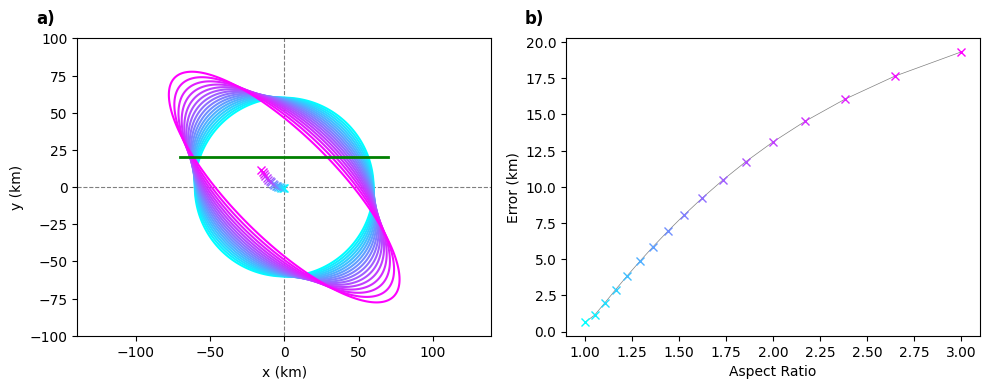

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

N = len(df_deform_tests)
cmap = plt.cm.cool
cols = cmap(np.linspace(0, 1, N))

# ------------------ RIGHT panel (was left) ------------------
axs[1].plot(df_deform_tests.AR, df_deform_tests.Err, lw=.5, color='k', alpha=.5)
for i, (ar, err) in enumerate(zip(df_deform_tests.AR, df_deform_tests.Err)):
    axs[1].plot(ar, err, marker='x', color=cols[i])

axs[1].set_xlabel('Aspect Ratio')
axs[1].set_ylabel('Error (km)')

# ------------------ Grid ------------------
width = 500
x = np.linspace(-width // 2, width // 2, 501)
y = np.linspace(-width // 2, width // 2, 501)
X, Y = np.meshgrid(x, y, indexing='ij')

# ------------------ LEFT panel (was right) ------------------
for i, (q11, q12, q22) in enumerate(zip(df_deform_tests.Q11,
                                      df_deform_tests.Q12,
                                      df_deform_tests.Q22)):
    rho2 = q11*X**2 + 2*q12*X*Y + q22*Y**2

    axs[0].contour(
        X, Y, rho2,
        levels=[Rc**2/2],
        colors=[cols[i]],
        linewidths=1.5
    )

for i, (xc_, yc_) in enumerate(zip(df_deform_tests.xc, df_deform_tests.yc)):
    axs[0].plot(xc_, yc_, marker='x', color=cols[i])

# reference transect
nic_, njc_, r_ = 250, 270, 70
x1 = x[nic_-r_:nic_+r_+1:skip]
y1 = np.array([y[njc_]] * len(x1))
axs[0].plot(x1, y1, color='g', lw=2)

axs[0].axis('equal')
axs[0].set_xlim(-100, 100)
axs[0].set_ylim(-100, 100)
axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')

axs[0].text(-0.1, 1.05, 'a)', transform=axs[0].transAxes, fontsize=12, fontweight='bold')
axs[1].text(-0.1, 1.05, 'b)', transform=axs[1].transAxes, fontsize=12, fontweight='bold')

axs[0].axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=-1, alpha=.5)
axs[0].axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=-1, alpha=.5)


plt.tight_layout()
